# Multi-class Classification

## Import the Libraries

In [91]:
import os
import shutil
import re
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Global Variable

In [92]:
INPUT_DIRECTORY = './dataset'
PROCESSED_DIRECTORY = './processed_dataset'
OUTPUT_DIRECTORY = './dataset_split'

## Preprocessing Image

In [93]:
def rename_files(directory):
    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    for category in categories:
        category_path = os.path.join(directory, category)
        files = [f for f in os.listdir(category_path)]
        
        for idx, file_name in enumerate(files):
            file_ext = os.path.splitext(file_name)[1]
            # Hilangkan semua simbol dan spasi, hanya menyisakan huruf dan angka
            category_cleaned = re.sub(r'[^a-zA-Z0-9]', '', category)
            # Nama file baru tanpa simbol, spasi, atau underscore
            new_name = f"{category_cleaned}{idx}{file_ext}"
            src_path = os.path.join(category_path, file_name)
            dest_path = os.path.join(category_path, new_name)
            
            counter = 1
            while os.path.exists(dest_path):
                new_name = f"{category_cleaned}{idx}{counter}{file_ext}"
                dest_path = os.path.join(category_path, new_name)
                counter += 1
            
            os.rename(src_path, dest_path)
        
        print(f"Renamed files in category '{category}'.")

directory = './dataset'
rename_files(directory)


Renamed files in category 'ayam'.
Renamed files in category 'brokoli'.
Renamed files in category 'ikan'.
Renamed files in category 'kambing'.
Renamed files in category 'kembang kol'.
Renamed files in category 'kentang'.
Renamed files in category 'kol'.
Renamed files in category 'labu'.
Renamed files in category 'mentimun'.
Renamed files in category 'paprika'.
Renamed files in category 'sapi'.
Renamed files in category 'tahu'.
Renamed files in category 'telur'.
Renamed files in category 'tempe'.
Renamed files in category 'tomat'.
Renamed files in category 'udang'.
Renamed files in category 'wortel'.


In [94]:
def preprocess_images(input_dir, output_dir, img_size=(224, 224)):
    categories = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
    
    for category in categories:
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)
        os.makedirs(output_category_path, exist_ok=True)
        
        files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        for file_name in files:
            src_file = os.path.join(category_path, file_name)
            dest_file = os.path.join(output_category_path, file_name)
            
            # Memproses gambar dengan penghapusan jika terjadi error
            try:
                img = tf.io.read_file(src_file)
                img = tf.image.decode_image(img, channels=3)
                img = tf.image.convert_image_dtype(img, tf.float32)
                img = tf.image.resize(img, img_size)
                img = tf.image.convert_image_dtype(img, tf.uint8)

                # Menyimpan gambar yang sudah diproses
                encoded_img = tf.io.encode_jpeg(img)
                tf.io.write_file(dest_file, encoded_img)
            except tf.errors.InvalidArgumentError:
                print(f"Error processing image: {src_file}. Deleting file.")
                os.remove(src_file)  # Hapus gambar yang error


In [95]:
#Lakukan preprocess image
preprocess_images(INPUT_DIRECTORY, PROCESSED_DIRECTORY)

In [ ]:
#untuk ngecek berapa gambar yang kehapus karena ga sesuai formatnya
def count_images_per_category(data_dir):
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    print("Jumlah gambar yang dihapus per kategori di seluruh data:")
    for category in categories:
        category_path = os.path.join(data_dir, category)
        image_count = len([f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        if(image_count<600):
            print(f"{category}: {600-image_count} gambar")
        else:
            print("All image sufficient.")

count_images_per_category('processed_dataset/')

Jumlah gambar yang dihapus per kategori di seluruh data:


## Split image into train, validation, and test

In [97]:
def split_data(processed_dir, output_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    categories = [d for d in os.listdir(processed_dir) if os.path.isdir(os.path.join(processed_dir, d))]
    
    for category in categories:
        category_path = os.path.join(processed_dir, category)
        files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(files)
        
        # Menentukan jumlah data untuk setiap set
        train_size = int(train_ratio * len(files))
        val_size = int(val_ratio * len(files))
        
        # Membagi file ke dalam set train, validation, dan test
        train_files = files[:train_size]
        val_files = files[train_size:train_size + val_size]
        test_files = files[train_size + val_size:]
        
        # Membuat folder dan menyalin file
        for split, split_files in zip(['train', 'validation', 'test'], [train_files, val_files, test_files]):
            split_dir = os.path.join(output_dir, split, category)
            os.makedirs(split_dir, exist_ok=True)
            
            for file_name in split_files:
                src_file = os.path.join(category_path, file_name)
                dest_file = os.path.join(split_dir, file_name)
                shutil.copy(src_file, dest_file)

In [98]:
#Lakukan preprocess image
split_data(PROCESSED_DIRECTORY, OUTPUT_DIRECTORY)

In [99]:
TRAIN_DIR = 'dataset_split/train/'
VALIDATION_DIR = 'dataset_split/validation/'
TEST_DIR = 'dataset_split/test/'

Let's explore the `./dataset` folder containing the images. There is a subdirectory for each class. In this case there will be 17 folders one for each food label in the alphabet.

The complete tree looks like this:

```
.└── dataset_split/
    ├── train/
    |    ├── ayam/
    |    │   ├── ayam1.jpg
    |    │   ├── ayam2.jpg
    |    │   └── ...
    |    ├── brokoli/
    |        ├── brokoli1.jpg
    |        ├── brokoli2.jpg
    |        └── ...
    |    ├── ...
    |    ├── telur/
    |    |    ├── telur1.jpg
    |    |    ├── telur2.jpg
    |    |    └── ...
    |    ├── tomat/
    |    |    ├── tomat1.jpg
    |    |    ├── tomat2.jpg
    |    |    └── ...
    |    ├── ...
    |    └── wortel/
    |        ├── wortel1.jpg
    |        ├── wortel2.jpg
    |        └── ...
    └── validation/
    |    ├── ayam/
    |    │   ├── ayam1.jpg
    |    │   ├── ayam2.jpg
    |    │   └── ...
    |    ├── brokoli/
    |        ├── brokoli1.jpg
    |        ├── brokoli2.jpg
    |        └── ...
    |    ├── ...
    |    ├── telur/
    |    |    ├── telur1.jpg
    |    |    ├── telur2.jpg
    |    |    └── ...
    |    ├── tomat/
    |    |    ├── tomat1.jpg
    |    |    ├── tomat2.jpg
    |    |    └── ...
    |    ├── ...
    |    └── wortel/
    |        ├── wortel1.jpg
    |        ├── wortel2.jpg
    |        └── ...
    └── test/
         ├── ayam/
         │   ├── ayam1.jpg
         │   ├── ayam2.jpg
         │   └── ...
         ├── brokoli/
         ├    ├── brokoli1.jpg
         ├    ├── brokoli2.jpg
         ├    └── ...
         ├── ...
         ├── telur/
         |    ├── telur1.jpg
         |    ├── telur2.jpg
         |    └── ...
         ├── tomat/
         |    ├── tomat1.jpg
         |    ├── tomat2.jpg
         |    └── ...
         ├── ...
         └── wortel/
             ├── wortel1.jpg
             ├── wortel2.jpg
             └── ...
``` 

## Display Images

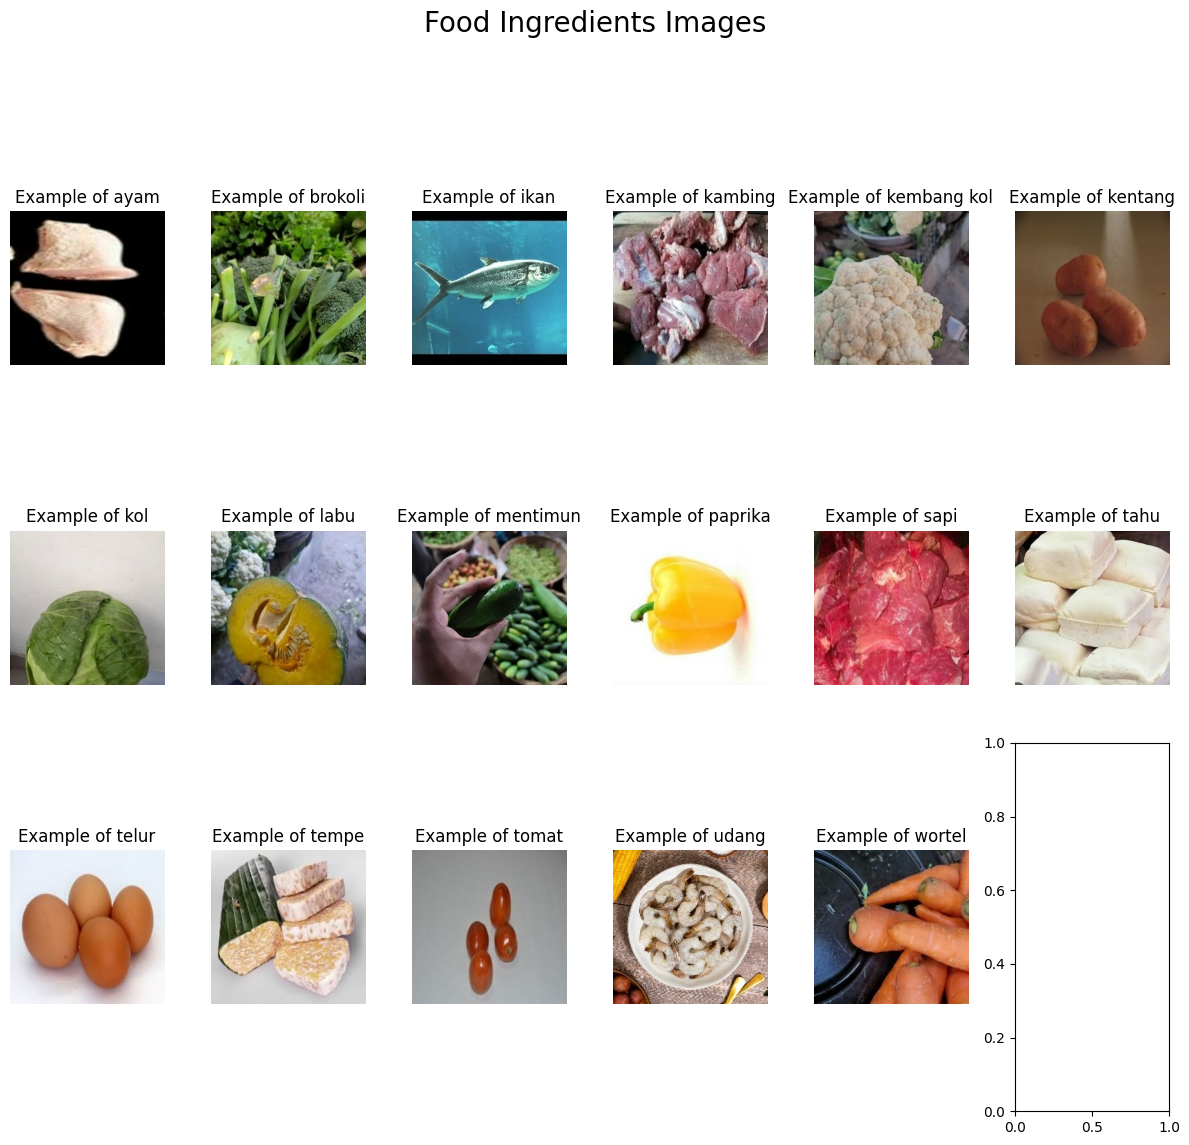

In [100]:
folder_names = os.listdir('./dataset_split/train')

num_columns = 6 
num_rows = (len(folder_names) + num_columns - 1) // num_columns 

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 4 * num_rows))
fig.suptitle('Food Ingredients Images', fontsize=20)

axes = axes.flatten()

for ii, folder in enumerate(folder_names):
    dir = f'./dataset_split/train/{folder}'
    
    if os.listdir(dir):  
        img_path = os.path.join(dir, os.listdir(dir)[0]) 
        img = tf.keras.preprocessing.image.load_img(img_path)  
        axes[ii].imshow(img)
        axes[ii].set_title(f'Example of {folder}')  
        axes[ii].axis('off')
    else:
        axes[ii].set_title(f'No images in {folder}') 
        axes[ii].axis('off')  
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [101]:
# Convert the image into its numpy array representation
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (224, 224, 3)


In [102]:
sample_array[0,:5]

array([[ 37.,  49.,  75.],
       [ 33.,  47.,  73.],
       [ 45.,  60.,  89.],
       [ 61.,  80., 110.],
       [ 74.,  97., 129.]], dtype=float32)

## Creating the datasets for the CNN

In [103]:
def train_val_datasets():
    train_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=TRAIN_DIR,
        batch_size=32,
        image_size=(224, 224),
		label_mode='categorical',
    ) 
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=VALIDATION_DIR,
        batch_size=32,
        image_size=(224, 224),
		label_mode='categorical',
    ) 

    test_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=TEST_DIR,
        batch_size=32,
        image_size=(224, 224),
		label_mode='categorical',
    ) 
    return train_dataset, validation_dataset, test_dataset

In [104]:
# Create train and validation datasets
train_dataset, validation_dataset,test_dataset = train_val_datasets()
print()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print()
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")   
print()
print(f"Images of test dataset have shape: {test_dataset.element_spec[0].shape}")
print(f"Labels of test dataset have shape: {test_dataset.element_spec[1].shape}")   

Found 6120 files belonging to 17 classes.
Found 2040 files belonging to 17 classes.
Found 2040 files belonging to 17 classes.

Images of train dataset have shape: (None, 224, 224, 3)
Labels of train dataset have shape: (None, 17)

Images of validation dataset have shape: (None, 224, 224, 3)
Labels of validation dataset have shape: (None, 17)

Images of test dataset have shape: (None, 224, 224, 3)
Labels of test dataset have shape: (None, 17)


In [105]:
for images, labels in train_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (32, 224, 224, 3)
Shape of batch of labels: (32, 17)


## Create Augmentation Model

In [106]:
# Define fill mode.
FILL_MODE = 'nearest'

# Create the augmentation model.
data_augmentation = tf.keras.Sequential([
    # Specify the input shape.
    tf.keras.Input(shape=(150,150,3)),
    # Add the augmentation layers
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
    ])

In [107]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

In [108]:
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 32


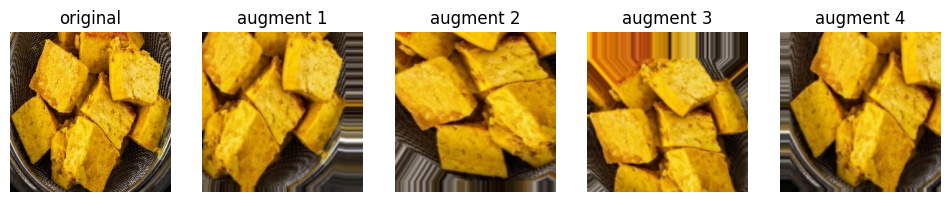

In [109]:
NUM_AUG = 4

demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)

## Coding the CNN

In [110]:
def create_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(224, 224, 3)), 
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(17, activation='softmax')
        ]) 
    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

In [111]:
model = create_model()

In [112]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 17)


In [113]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 224, 224, 3)
Output shape: (None, 17)


In [114]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 788544)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 788544)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │   100,933,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,937,745 (385.05 MB)

 Trainable params: 100,937,745 (385.05 MB)

 Non-trainable params: 0 (0.00 B)

# Train your model

In [ ]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)

Epoch 1/5
119/192 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.1562 - loss: 23.5728

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()